In [1]:
import keras
keras.__version__

Using TensorFlow backend.


'2.0.8'

# Advanced usage of recurrent neural networks
# 循环神经网络的高级用法

This notebook contains the code samples found in Chapter 6, Section 3 of [Deep Learning with Python](https://www.manning.com/books/deep-learning-with-python?a_aid=keras&a_bid=76564dff). Note that the original text features far more content, in particular further explanations and figures: in this notebook, you will only find source code and related comments.

---

In this section, we will review three advanced techniques for improving the performance and generalization power of recurrent neural 
networks. By the end of the section, you will know most of what there is to know about using recurrent networks with Keras. We will 
demonstrate all three concepts on a weather forecasting problem, where we have access to a timeseries of data points coming from sensors 
installed on the roof of a building, such as temperature, air pressure, and humidity, which we use to predict what the temperature will be 
24 hours after the last data point collected. This is a fairly challenging problem that exemplifies many common difficulties encountered 
when working with timeseries.

We will cover the following techniques:

* *Recurrent dropout*, a specific, built-in way to use dropout to fight overfitting in recurrent layers.
* *Stacking recurrent layers*, to increase the representational power of the network (at the cost of higher computational loads).
* *Bidirectional recurrent layers*, which presents the same information to a recurrent network in different ways, increasing accuracy and mitigating forgetting issues.

本节将介绍提高循环神经网络的性能和泛化能力的三种高级技巧。学完本节，你将会掌握 用 Keras 实现循环网络的大部分内容。我们将在温度预测问题中介绍这三个概念。在这个问题中， 数据点时间序列来自建筑物屋顶安装的传感器，包括温度、气压、湿度等，你将要利用这些数 据来预测最后一个数据点24小时之后的温度。这是一个相当有挑战性的问题，其中包含许多处 理时间序列时经常遇到的困难。

我们将会介绍以下三种技巧。
* 循环 dropout（recurrent dropout）。这是一种特殊的内置方法，在循环层中使用 dropout来降低过拟合。
* 堆叠循环层（stacking recurrent layers）。这会提高网络的表示能力（代价是更高的计算负荷）。
* 双向循环层（bidirectional recurrent layer）。将相同的信息以不同的方式呈现给循环网络，可以提高精度并缓解遗忘问题。


## A temperature forecasting problem

Until now, the only sequence data we have covered has been text data, for instance the IMDB dataset and the Reuters dataset. But sequence 
data is found in many more problems than just language processing. In all of our examples in this section, we will be playing with a weather 
timeseries dataset recorded at the Weather Station at the Max-Planck-Institute for Biogeochemistry in Jena, Germany: http://www.bgc-jena.mpg.de/wetter/.

In this dataset, fourteen different quantities (such air temperature, atmospheric pressure, humidity, wind direction, etc.) are recorded 
every ten minutes, over several years. The original data goes back to 2003, but we limit ourselves to data from 2009-2016. This dataset is 
perfect for learning to work with numerical timeseries. We will use it to build a model that takes as input some data from the recent past (a 
few days worth of data points) and predicts the air temperature 24 hours in the future.

##  温度预测问题

到目前为止，我们遇到的唯一一种序列数据就是文本数据，比如 IMDB 数据集和路透社 数据集。但除了语言处理，其他许多问题中也都用到了序列数据。在本节的所有例子中，我 们将使用一个天气时间序列数据集，它由德国耶拿的马克思 • 普朗克生物地球化学研究所的气象站记录。

在这个数据集中，每 10 分钟记录 14 个不同的量（比如气温、气压、湿度、风向等），其中包含多年的记录。原始数据可追溯到 2003 年，但本例仅使用 2009—2016 年的数据。这个数据集非常适合用来学习处理数值型时间序列。我们将会用这个数据集来构建模型，输入最近的一 些数据（几天的数据点），可以预测 24 小时之后的气温。

备注：我们下载好了，文件路径： 'data/jena_climate_2009_2016.csv'

Let's take a look at the data:

来观察一下数据。

In [1]:
import os

data_dir = 'data/'
fname = os.path.join(data_dir, 'jena_climate_2009_2016.csv')

f = open(fname)
data = f.read()
f.close()

lines = data.split('\n')
header = lines[0].split(',')
lines = lines[1:]

print(header)
print(len(lines))

['"Date Time"', '"p (mbar)"', '"T (degC)"', '"Tpot (K)"', '"Tdew (degC)"', '"rh (%)"', '"VPmax (mbar)"', '"VPact (mbar)"', '"VPdef (mbar)"', '"sh (g/kg)"', '"H2OC (mmol/mol)"', '"rho (g/m**3)"', '"wv (m/s)"', '"max. wv (m/s)"', '"wd (deg)"']
420551


Let's convert all of these 420,551 lines of data into a Numpy array:

接下来，将 420 551 行数据转换成一个 Numpy 数组。

In [2]:
import numpy as np

float_data = np.zeros((len(lines), len(header) - 1))
for i, line in enumerate(lines):
    values = [float(x) for x in line.split(',')[1:]]
    float_data[i, :] = values

For instance, here is the plot of temperature (in degrees Celsius) over time:

比如，温度随时间的变化如下图所示（单位：摄氏度）

In [ ]:
fname.head()

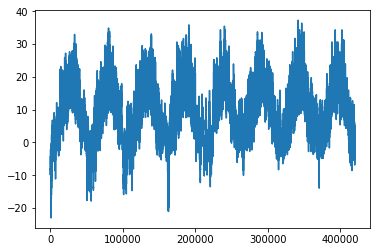

In [4]:
from matplotlib import pyplot as plt

temp = float_data[:, 1]  # temperature (in degrees Celsius)（温度（单位：摄氏度））
plt.plot(range(len(temp)), temp)
plt.show()


On this plot, you can clearly see the yearly periodicity of temperature.

Here is a more narrow plot of the first ten days of temperature data (since the data is recorded every ten minutes, we get 144 data points 
per day):

在这张图中，你可以清楚地看 到温度每年的周期性变化。

上图给出了前 10 天温度数据的图像。因为每 10 分钟记录一个数据，所以每天有 144 个 数据点。


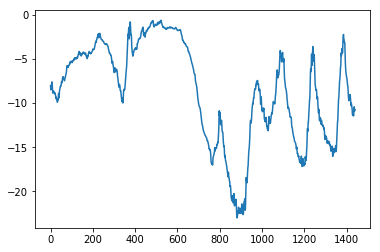

In [5]:
plt.plot(range(1440), temp[:1440])
plt.show()


On this plot, you can see daily periodicity, especially evident for the last 4 days. We can also note that this ten-days period must be 
coming from a fairly cold winter month.

If we were trying to predict average temperature for the next month given a few month of past data, the problem would be easy, due to the 
reliable year-scale periodicity of the data. But looking at the data over a scale of days, the temperature looks a lot more chaotic. So is 
this timeseries predictable at a daily scale? Let's find out.

在这张图中，你可以看到每天的周期性变化，尤其是最后 4 天特别明显。另外请注意，这10天一定是来自于很冷的冬季月份。 

如果你想根据过去几个月的数据来预测下个月的平均温度，那么问题很简单，因为数据具有可靠的年度周期性。但从几天的数据来看，温度看起来更混乱一些。以天作为观察尺度，这个时间序列是可以预测的吗？我们来寻找这个问题的答案。


## Preparing the data


The exact formulation of our problem will be the following: given data going as far back as `lookback` timesteps (a timestep is 10 minutes) 
and sampled every `steps` timesteps, can we predict the temperature in `delay` timesteps?

We will use the following parameter values:

* `lookback = 720`, i.e. our observations will go back 5 days.
* `steps = 6`, i.e. our observations will be sampled at one data point per hour.
* `delay = 144`, i.e. our targets will be 24 hours in the future.

To get started, we need to do two things:

* Preprocess the data to a format a neural network can ingest. This is easy: the data is already numerical, so we don't need to do any 
vectorization. However each timeseries in the data is on a different scale (e.g. temperature is typically between -20 and +30, but 
pressure, measured in mbar, is around 1000). So we will normalize each timeseries independently so that they all take small values on a 
similar scale.
* Write a Python generator that takes our current array of float data and yields batches of data from the recent past, alongside with a 
target temperature in the future. Since the samples in our dataset are highly redundant (e.g. sample `N` and sample `N + 1` will have most 
of their timesteps in common), it would be very wasteful to explicitly allocate every sample. Instead, we will generate the samples on the 
fly using the original data.

We preprocess the data by subtracting the mean of each timeseries and dividing by the standard deviation. We plan on using the first 
200,000 timesteps as training data, so we compute the mean and standard deviation only on this fraction of the data:
## 准备数据
这个问题的确切表述如下：一个时间步是 10 分钟，每 steps 个时间步采样一次数据，给定过去 lookback 个时间步之内的数据，能否预测 delay 个时间步之后的温度？用到的参数值 如下。

* lookback = 720：给定过去 5 天内的观测数据。
* steps = 6：观测数据的采样频率是每小时一个数据点。
* delay = 144：目标是未来 24 小时之后的数据。 开始之前，你需要完成以下两件事。
* 将数据预处理为神经网络可以处理的格式。这很简单。数据已经是数值型的，所以不需要做向量化。但数据中的每个时间序列位于不同的范围（比如温度通道位于 -20 到 +30 之间，但气压大约在 1000 毫巴上下）。你需要对每个时间序列分别做标准化，让它们在相似的范围内都取较小的值。
* 编写一个 Python 生成器，以当前的浮点数数组作为输入，并从最近的数据中生成数据批量，同时生成未来的目标温度。因为数据集中的样本是高度冗余的（对于第 N 个样本和第 N+1 个样本，大部分时间步都是相同的），所以显式地保存每个样本是一种浪费。相反，我们将使用原始数据即时生成样本。
 
预处理数据的方法是，将每个时间序列减去其平均值，然后除以其标准差。我们将使用前200 000 个时间步作为训练数据，所以只对这部分数据计算平均值和标准差。


In [6]:
mean = float_data[:200000].mean(axis=0)
float_data -= mean
std = float_data[:200000].std(axis=0)
float_data /= std


Now here is the data generator that we will use. It yields a tuple `(samples, targets)` where `samples` is one batch of input data and 
`targets` is the corresponding array of target temperatures. It takes the following arguments:

* `data`: The original array of floating point data, which we just normalized in the code snippet above.
* `lookback`: How many timesteps back should our input data go.
* `delay`: How many timesteps in the future should our target be.
* `min_index` and `max_index`: Indices in the `data` array that delimit which timesteps to draw from. This is useful for keeping a segment 
of the data for validation and another one for testing.
* `shuffle`: Whether to shuffle our samples or draw them in chronological order.
* `batch_size`: The number of samples per batch.
* `step`: The period, in timesteps, at which we sample data. We will set it 6 in order to draw one data point every hour.

代码清单给出了将要用到的生成器。它生成了一个元组 (samples, targets)，其 中 samples 是输入数据的一个批量，targets 是对应的目标温度数组。生成器的参数如下。
* data：浮点数数据组成的原始数组，在代码清单 6-32 中将其标准化。
* lookback：输入数据应该包括过去多少个时间步。
* delay：目标应该在未来多少个时间步之后。
* min_index 和 max_index：data 数组中的索引，用于界定需要抽取哪些时间步。这有助于保存一部分数据用于验证、另一部分用于测试。
* shuffle：是打乱样本，还是按顺序抽取样本。
* batch_size：每个批量的样本数。
* step：数据采样的周期（单位：时间步）。我们将其设为 6，为的是每小时抽取一个数据点。


In [7]:
def generator(data, lookback, delay, min_index, max_index,
              shuffle=False, batch_size=128, step=6):
    if max_index is None:
        max_index = len(data) - delay - 1
    i = min_index + lookback
    while 1:
        if shuffle:
            rows = np.random.randint(
                min_index + lookback, max_index, size=batch_size)
        else:
            if i + batch_size >= max_index:
                i = min_index + lookback
            rows = np.arange(i, min(i + batch_size, max_index))
            i += len(rows)

        samples = np.zeros((len(rows),
                           lookback // step,
                           data.shape[-1]))
        targets = np.zeros((len(rows),))
        for j, row in enumerate(rows):
            indices = range(rows[j] - lookback, rows[j], step)
            samples[j] = data[indices]
            targets[j] = data[rows[j] + delay][1]
        yield samples, targets


Now let's use our abstract generator function to instantiate three generators, one for training, one for validation and one for testing. 
Each will look at different temporal segments of the original data: the training generator looks at the first 200,000 timesteps, the 
validation generator looks at the following 100,000, and the test generator looks at the remainder.

下面，我们使用这个抽象的 generator 函数来实例化三个生成器：一个用于训练，一个用于验证，还有一个用于测试。每个生成器分别读取原始数据的不同时间段：训练生成器读取前200 000 个时间步，验证生成器读取随后的 100 000 个时间步，测试生成器读取剩下的时间步。


In [8]:
lookback = 1440
step = 6
delay = 144
batch_size = 128

train_gen = generator(float_data,
                      lookback=lookback,
                      delay=delay,
                      min_index=0,
                      max_index=200000,
                      shuffle=True,
                      step=step, 
                      batch_size=batch_size)
val_gen = generator(float_data,
                    lookback=lookback,
                    delay=delay,
                    min_index=200001,
                    max_index=300000,
                    step=step,
                    batch_size=batch_size)
test_gen = generator(float_data,
                     lookback=lookback,
                     delay=delay,
                     min_index=300001,
                     max_index=None,
                     step=step,
                     batch_size=batch_size)

# This is how many steps to draw from `val_gen`
# in order to see the whole validation set:
# 为了查看整个验证集，需要 从 val_gen 中抽取多少次
val_steps = (300000 - 200001 - lookback) // batch_size

# This is how many steps to draw from `test_gen`
# in order to see the whole test set:
# 为了查看整个测试集，需要从 test_gen 中抽取多少次
test_steps = (len(float_data) - 300001 - lookback) // batch_size

## A common sense, non-machine learning baseline


Before we start leveraging black-box deep learning models to solve our temperature prediction problem, let's try out a simple common-sense 
approach. It will serve as a sanity check, and it will establish a baseline that we will have to beat in order to demonstrate the 
usefulness of more advanced machine learning models. Such common-sense baselines can be very useful when approaching a new problem for 
which there is no known solution (yet). A classic example is that of unbalanced classification tasks, where some classes can be much more 
common than others. If your dataset contains 90% of instances of class A and 10% of instances of class B, then a common sense approach to 
the classification task would be to always predict "A" when presented with a new sample. Such a classifier would be 90% accurate overall, 
and any learning-based approach should therefore beat this 90% score in order to demonstrate usefulness. Sometimes such elementary 
baseline can prove surprisingly hard to beat.

In our case, the temperature timeseries can safely be assumed to be continuous (the temperatures tomorrow are likely to be close to the 
temperatures today) as well as periodical with a daily period. Thus a common sense approach would be to always predict that the temperature 
24 hours from now will be equal to the temperature right now. Let's evaluate this approach, using the Mean Absolute Error metric (MAE). 
Mean Absolute Error is simply equal to:

## 一种基于常识的、非机器学习的基准方法

开始使用黑盒深度学习模型解决温度预测问题之前，我们先尝试一种基于常识的简单方法。 它可以作为合理性检查，还可以建立一个基准，更高级的机器学习模型需要打败这个基准才能 表现出其有效性。面对一个尚没有已知解决方案的新问题时，这种基于常识的基准方法很有用。 一个经典的例子就是不平衡的分类任务，其中某些类别比其他类别更常见。如果数据集中包含90% 的类别 A 实例和 10% 的类别 B 实例，那么分类任务的一种基于常识的方法就是对新样本 始终预测类别“A”。这种分类器的总体精度为 90%，因此任何基于学习的方法在精度高于 90% 时才能证明其有效性。有时候，这样基本的基准方法可能很难打败。

本例中，我们可以放心地假设，温度时间序列是连续的（明天的温度很可能接近今天的温度），并且具有每天的周期性变化。因此，一种基于常识的方法就是始终预测 24 小时后的温度 等于现在的温度。我们使用平均绝对误差（MAE）指标来评估这种方法。


np.mean(np.abs(preds - targets))

Here's our evaluation loop:

下面是评估的循环代码。

In [10]:
def evaluate_naive_method():
    batch_maes = []
    for step in range(val_steps):
        samples, targets = next(val_gen)
        preds = samples[:, -1, 1]
        mae = np.mean(np.abs(preds - targets))
        batch_maes.append(mae)
    print(np.mean(batch_maes))
    
evaluate_naive_method()

0.289735972991


It yields a MAE of 0.29. Since our temperature data has been normalized to be centered on 0 and have a standard deviation of one, this 
number is not immediately interpretable. It translates to an average absolute error of `0.29 * temperature_std` degrees Celsius, i.e. 
2.57˚C. That's a fairly large average absolute error -- now the game is to leverage our knowledge of deep learning to do better. 

得到的 MAE 为 0.29。因为温度数据被标准化成均值为 0、标准差为 1，所以无法直接对这个值进行解释。它转化成温度的平均绝对误差为0.29×temperature_std 摄氏度，即 2.57℃。绝对误差还是相当大的。接下来的任务是利用深度学习知识来改进结果。

## A basic machine learning approach

In the same way that it is useful to establish a common sense baseline before trying machine learning approaches, it is useful to try 
simple and cheap machine learning models (such as small densely-connected networks) before looking into complicated and computationally 
expensive models such as RNNs. This is the best way to make sure that any further complexity we throw at the problem later on is legitimate 
and delivers real benefits.

Here is a simply fully-connected model in which we start by flattening the data, then run it through two `Dense` layers. Note the lack of 
activation function on the last `Dense` layer, which is typical for a regression problem. We use MAE as the loss. Since we are evaluating 
on the exact same data and with the exact same metric as with our common sense approach, the results will be directly comparable.

## 一种基本的机器学习方法

在尝试机器学习方法之前，建立一个基于常识的基准方法是很有用的；同样，在开始研究 复杂且计算代价很高的模型（比如 RNN）之前，尝试使用简单且计算代价低的机器学习模型也是很有用的，比如小型的密集连接网络。这可以保证进一步增加问题的复杂度是合理的，并且会带来真正的好处。

下面的代码清单给出了一个密集连接模型，首先将数据展平，然后通过两个Dense 层并运行。 注意，最后一个 Dense 层没有使用激活函数，这对于回归问题是很常见的。我们使用 MAE 作 为损失。评估数据和评估指标都与常识方法完全相同，所以可以直接比较两种方法的结果。


In [11]:
from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop

model = Sequential()
model.add(layers.Flatten(input_shape=(lookback // step, float_data.shape[-1])))
model.add(layers.Dense(32, activation='relu'))
model.add(layers.Dense(1))

model.compile(optimizer=RMSprop(), loss='mae')
history = model.fit_generator(train_gen,
                              steps_per_epoch=500,
                              epochs=20,
                              validation_data=val_gen,
                              validation_steps=val_steps)

Using TensorFlow backend.


Epoch 1/20
500/500 [==============================] - 15s 30ms/step - loss: 0.9271 - val_loss: 0.4560
Epoch 2/20
500/500 [==============================] - 13s 25ms/step - loss: 0.3413 - val_loss: 0.3067
Epoch 3/20
500/500 [==============================] - 13s 25ms/step - loss: 0.2850 - val_loss: 0.3491
Epoch 4/20
500/500 [==============================] - 13s 25ms/step - loss: 0.2651 - val_loss: 0.3085
Epoch 5/20
500/500 [==============================] - 13s 25ms/step - loss: 0.2547 - val_loss: 0.3041
Epoch 6/20
500/500 [==============================] - 13s 25ms/step - loss: 0.2488 - val_loss: 0.3594
Epoch 7/20
500/500 [==============================] - 13s 25ms/step - loss: 0.2419 - val_loss: 0.3169
Epoch 8/20
500/500 [==============================] - 13s 26ms/step - loss: 0.2360 - val_loss: 0.3223
Epoch 9/20
500/500 [==============================] - 13s 25ms/step - loss: 0.2286 - val_loss: 0.3235
Epoch 10/20
500/500 [==============================] - 13s 25ms/step - loss: 0.225

Let's display the loss curves for validation and training:

我们来显示验证和训练的损失曲线

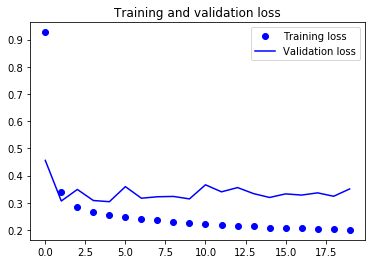

In [12]:
import matplotlib.pyplot as plt

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(loss))

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()


Some of our validation losses get close to the no-learning baseline, but not very reliably. This goes to show the merit of having had this baseline in the first place: it turns out not to be so easy to outperform. Our 
common sense contains already a lot of valuable information that a machine learning model does not have access to.

You may ask, if there exists a simple, well-performing model to go from the data to the targets (our common sense baseline), why doesn't 
the model we are training find it and improve on it? Simply put: because this simple solution is not what our training setup is looking 
for. The space of models in which we are searching for a solution, i.e. our hypothesis space, is the space of all possible 2-layer networks 
with the configuration that we defined. These networks are already fairly complicated. When looking for a solution with a space of 
complicated models, the simple well-performing baseline might be unlearnable, even if it's technically part of the hypothesis space. That 
is a pretty significant limitation of machine learning in general: unless the learning algorithm is hard-coded to look for a specific kind 
of simple model, parameter learning can sometimes fail to find a simple solution to a simple problem.

部分验证损失接近不包含学习的基准方法，但这个结果并不可靠。这也展示了首先建立这个基准方法的优点，事实证明，超越这个基准并不容易。我们的常识中包含了大量有价值的信息，而机器学习模型并不知道这些信息。

你可能会问，如果从数据到目标之间存在一个简单且表现良好的模型（即基于常识的基准 方法），那为什么我们训练的模型没有找到这个模型并进一步改进呢？原因在于，这个简单的解决方案并不是训练过程所要寻找的目标。我们在模型空间（即假设空间）中搜索解决方案，这个模型空间是具有我们所定义的架构的所有两层网络组成的空间。这些网络已经相当复杂了。 

如果你在一个复杂模型的空间中寻找解决方案，那么可能无法学到简单且性能良好的基准方法， 虽然技术上来说它属于假设空间的一部分。通常来说，这对机器学习是一个非常重要的限制： 如果学习算法没有被硬编码要求去寻找特定类型的简单模型，那么有时候参数学习是无法找到 简单问题的简单解决方案的。



## A first recurrent baseline


Our first fully-connected approach didn't do so well, but that doesn't mean machine learning is not applicable to our problem. The approach 
above consisted in first flattening the timeseries, which removed the notion of time from the input data. Let us instead look at our data 
as what it is: a sequence, where causality and order matter. We will try a recurrent sequence processing model -- it should be the perfect 
fit for such sequence data, precisely because it does exploit the temporal ordering of data points, unlike our first approach.

Instead of the `LSTM` layer introduced in the previous section, we will use the `GRU` layer, developed by Cho et al. in 2014. `GRU` layers 
(which stands for "gated recurrent unit") work by leveraging the same principle as LSTM, but they are somewhat streamlined and thus cheaper 
to run, albeit they may not have quite as much representational power as LSTM. This trade-off between computational expensiveness and 
representational power is seen everywhere in machine learning.

## 第一个循环网络基准

第一个全连接方法的效果并不好，但这并不意味着机器学习不适用于这个问题。前一个方法首先将时间序列展平，这从输入数据中删除了时间的概念。我们来看一下数据本来的样子： 它是一个序列，其中因果关系和顺序都很重要。我们将尝试一种循环序列处理模型，它应该特别适合这种序列数据，因为它利用了数据点的时间顺序，这与第一个方法不同。

我们将使用 Chung 等人在2014 年开发的 GRU 层，而不是上一节介绍的 LSTM 层。门控循环单元（GRU，gated recurrent unit）层的工作原理与 LSTM 相同。但它做了一些简化，因此运行的计算代价更低（虽然表示能力可能不如 LSTM）。机器学习中到处可以见到这种计算代价与表示能力之间的折中。


In [13]:
from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop

model = Sequential()
model.add(layers.GRU(32, input_shape=(None, float_data.shape[-1])))
model.add(layers.Dense(1))

model.compile(optimizer=RMSprop(), loss='mae')
history = model.fit_generator(train_gen,
                              steps_per_epoch=500,
                              epochs=20,
                              validation_data=val_gen,
                              validation_steps=val_steps)

Epoch 1/20
500/500 [==============================] - 229s 458ms/step - loss: 0.3056 - val_loss: 0.2703
Epoch 2/20
500/500 [==============================] - 228s 457ms/step - loss: 0.2851 - val_loss: 0.2690
Epoch 3/20
500/500 [==============================] - 230s 460ms/step - loss: 0.2774 - val_loss: 0.2658
Epoch 4/20
500/500 [==============================] - 228s 456ms/step - loss: 0.2743 - val_loss: 0.2642
Epoch 5/20
500/500 [==============================] - 230s 459ms/step - loss: 0.2690 - val_loss: 0.2678
Epoch 6/20
500/500 [==============================] - 229s 458ms/step - loss: 0.2668 - val_loss: 0.2622
Epoch 7/20
500/500 [==============================] - 227s 455ms/step - loss: 0.2613 - val_loss: 0.2647
Epoch 8/20
500/500 [==============================] - 229s 458ms/step - loss: 0.2583 - val_loss: 0.2673
Epoch 9/20
500/500 [==============================] - 230s 459ms/step - loss: 0.2524 - val_loss: 0.2685
Epoch 10/20
500/500 [==============================] - 233s 466m

Let look at our results:

看下结果：

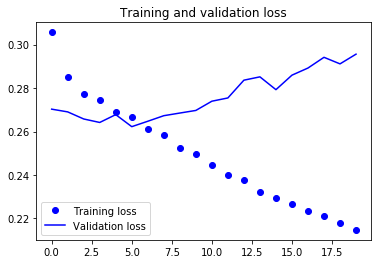

In [14]:
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(loss))

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()


Much better! We are able to significantly beat the common sense baseline, such demonstrating the value of machine learning here, as well as 
the superiority of recurrent networks compared to sequence-flattening dense networks on this type of task.

Our new validation MAE of ~0.265 (before we start significantly overfitting) translates to a mean absolute error of 2.35˚C after 
de-normalization. That's a solid gain on our initial error of 2.57˚C, but we probably still have a bit of margin for improvement.

效果好多了！远优于基于常识的基准方法。这证明了机器学习的价值，也证明了循环网络与序列展平的密集网络相比在这种任务上的优势。

新的验证 MAE 约为 0.265（在开始显著过拟合之前），反标准化转换成温度的平均绝对误差为 2.35℃。与最初的误差 2.57℃相比，这个结果确实有所提高，但可能仍有改进的空间。


## Using recurrent dropout to fight overfitting


It is evident from our training and validation curves that our model is overfitting: the training and validation losses start diverging 
considerably after a few epochs. You are already familiar with a classic technique for fighting this phenomenon: dropout, consisting in 
randomly zeroing-out input units of a layer in order to break happenstance correlations in the training data that the layer is exposed to. 
How to correctly apply dropout in recurrent networks, however, is not a trivial question. It has long been known that applying dropout 
before a recurrent layer hinders learning rather than helping with regularization. In 2015, Yarin Gal, as part of his Ph.D. thesis on 
Bayesian deep learning, determined the proper way to use dropout with a recurrent network: the same dropout mask (the same pattern of 
dropped units) should be applied at every timestep, instead of a dropout mask that would vary randomly from timestep to timestep. What's 
more: in order to regularize the representations formed by the recurrent gates of layers such as GRU and LSTM, a temporally constant 
dropout mask should be applied to the inner recurrent activations of the layer (a "recurrent" dropout mask). Using the same dropout mask at 
every timestep allows the network to properly propagate its learning error through time; a temporally random dropout mask would instead 
disrupt this error signal and be harmful to the learning process.

Yarin Gal did his research using Keras and helped build this mechanism directly into Keras recurrent layers. Every recurrent layer in Keras 
has two dropout-related arguments: `dropout`, a float specifying the dropout rate for input units of the layer, and `recurrent_dropout`, 
specifying the dropout rate of the recurrent units. Let's add dropout and recurrent dropout to our GRU layer and see how it impacts 
overfitting. Because networks being regularized with dropout always take longer to fully converge, we train our network for twice as many 
epochs.

## 使用循环 dropout 来降低过拟合

从训练和验证曲线中可以明显看出，模型出现过拟合：几轮过后，训练损失和验证损失就开始显著偏离。我们已经学过降低过拟合的一种经典技术——dropout，即将某一层的输入单元随机设为 0，其目的是打破该层训练数据中的偶然相关性。但在循环网络中如何正确地使用 dropout，这并不是一个简单的问题。人们早就知道，在循环层前面应用 dropout，这种正则化会妨碍学习过程，而不是有所帮助。2015 年，在关于贝叶斯深度学习的博士论文中，Yarin Gal 确定了在循环网络中使用 dropout 的正确方法：对每个时间步应该使用相同的 dropout 掩码（dropout mask，相同模式的舍弃单元），而不是让 dropout 掩码随着时间步的增加而随机变化。此外，为了对 GRU、LSTM 等循环层得到的表示做正则化，应该将不随时间变化的 dropout 掩码应用于层的内部循环激活（叫作循环 dropout 掩码）。对每个时间步使用相同的 dropout 掩码，可以让网络沿着时间正确地传播其学习误差，而随时间随机变化的 dropout 掩码则会破坏这个误差信号，并且不利于学习过程。

Yarin Gal 使用 Keras 开展这项研究，并帮助将这种机制直接内置到 Keras 循环层中。Keras 的每个循环层都有两个与 dropout 相关的参数：一个是dropout，它是一个浮点数，指定该层输入单元的 dropout 比率；另一个是 recurrent_dropout，指定循环单元的 dropout 比率。我们向 GRU 层中添加 dropout和循环 dropout，看一下这么做对过拟合的影响。因为使用 dropout 正则化的网络总是需要更长的时间才能完全收敛，所以网络训练轮次增加为原来的 2 倍。




In [15]:
from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop

model = Sequential()
model.add(layers.GRU(32,
                     dropout=0.2,
                     recurrent_dropout=0.2,
                     input_shape=(None, float_data.shape[-1])))
model.add(layers.Dense(1))

model.compile(optimizer=RMSprop(), loss='mae')
history = model.fit_generator(train_gen,
                              steps_per_epoch=500,
                              epochs=40,
                              validation_data=val_gen,
                              validation_steps=val_steps)

Epoch 1/40
500/500 [==============================] - 259s 519ms/step - loss: 0.3349 - val_loss: 0.2725
Epoch 2/40
500/500 [==============================] - 259s 517ms/step - loss: 0.3136 - val_loss: 0.2728
Epoch 3/40
500/500 [==============================] - 258s 515ms/step - loss: 0.3066 - val_loss: 0.2724
Epoch 4/40
500/500 [==============================] - 257s 515ms/step - loss: 0.3028 - val_loss: 0.2685
Epoch 5/40
500/500 [==============================] - 258s 515ms/step - loss: 0.2978 - val_loss: 0.2663
Epoch 6/40
500/500 [==============================] - 259s 518ms/step - loss: 0.2970 - val_loss: 0.2685
Epoch 7/40
500/500 [==============================] - 258s 517ms/step - loss: 0.2948 - val_loss: 0.2654
Epoch 8/40
500/500 [==============================] - 257s 514ms/step - loss: 0.2915 - val_loss: 0.2660
Epoch 9/40
500/500 [==============================] - 257s 514ms/step - loss: 0.2928 - val_loss: 0.2671
Epoch 10/40
500/500 [==============================] - 257s 515m

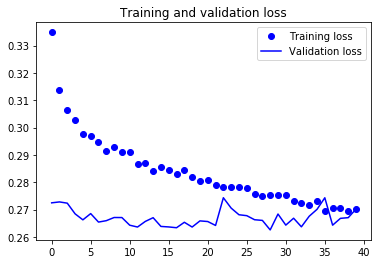

In [16]:
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(loss))

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

Great success; we are no longer overfitting during the first 30 epochs. However, while we have more stable evaluation scores, our best 
scores are not much lower than they were previously.

成功！前 30 个轮次不再过拟合。不过，虽然评估分数更加稳定，但最佳分数并没有比之前低很多。

## Stacking recurrent layers

Since we are no longer overfitting yet we seem to have hit a performance bottleneck, we should start considering increasing the capacity of 
our network. If you remember our description of the "universal machine learning workflow": it is a generally a good idea to increase the 
capacity of your network until overfitting becomes your primary obstacle (assuming that you are already taking basic steps to mitigate 
overfitting, such as using dropout). As long as you are not overfitting too badly, then you are likely under-capacity.

Increasing network capacity is typically done by increasing the number of units in the layers, or adding more layers. Recurrent layer 
stacking is a classic way to build more powerful recurrent networks: for instance, what currently powers the Google translate algorithm is 
a stack of seven large LSTM layers -- that's huge.

To stack recurrent layers on top of each other in Keras, all intermediate layers should return their full sequence of outputs (a 3D tensor) 
rather than their output at the last timestep. This is done by specifying `return_sequences=True`: 

## 循环层堆叠

模型不再过拟合，但似乎遇到了性能瓶颈，所以我们应该考虑增加网络容量。回想一下机 器学习的通用工作流程：增加网络容量通常是一个好主意，直到过拟合变成主要的障碍（假设你已经采取基本步骤来降低过拟合，比如使用 dropout）。只要过拟合不是太严重，那么很可能是容量不足的问题。

增加网络容量的通常做法是增加每层单元数或增加层数。循环层堆叠（recurrent layer stacking）是构建更加强大的循环网络的经典方法，例如，目前谷歌翻译算法就是 7 个大型LSTM 层的堆叠——这个架构很大。

在 Keras 中逐个堆叠循环层，所有中间层都应该返回完整的输出序列（一个 3D 张量），而不是只返回最后一个时间步的输出。这可以通过指定return_sequences=True 来实现。


In [17]:
from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop

model = Sequential()
model.add(layers.GRU(32,
                     dropout=0.1,
                     recurrent_dropout=0.5,
                     return_sequences=True,
                     input_shape=(None, float_data.shape[-1])))
model.add(layers.GRU(64, activation='relu',
                     dropout=0.1, 
                     recurrent_dropout=0.5))
model.add(layers.Dense(1))

model.compile(optimizer=RMSprop(), loss='mae')
history = model.fit_generator(train_gen,
                              steps_per_epoch=500,
                              epochs=40,
                              validation_data=val_gen,
                              validation_steps=val_steps)

Epoch 1/40
500/500 [==============================] - 533s 1s/step - loss: 0.3353 - val_loss: 0.2806
Epoch 2/40
500/500 [==============================] - 531s 1s/step - loss: 0.3133 - val_loss: 0.2737
Epoch 3/40
500/500 [==============================] - 531s 1s/step - loss: 0.3072 - val_loss: 0.2716
Epoch 4/40
500/500 [==============================] - 529s 1s/step - loss: 0.3032 - val_loss: 0.2665
Epoch 5/40
500/500 [==============================] - 534s 1s/step - loss: 0.2978 - val_loss: 0.2668
Epoch 6/40
500/500 [==============================] - 532s 1s/step - loss: 0.2966 - val_loss: 0.2656
Epoch 7/40
500/500 [==============================] - 533s 1s/step - loss: 0.2932 - val_loss: 0.2654
Epoch 8/40
500/500 [==============================] - 533s 1s/step - loss: 0.2921 - val_loss: 0.2707
Epoch 9/40
500/500 [==============================] - 532s 1s/step - loss: 0.2881 - val_loss: 0.2717
Epoch 10/40
500/500 [==============================] - 530s 1s/step - loss: 0.2857 - val_lo

Let's take a look at our results:

看下结果：

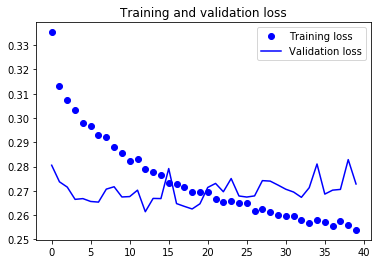

In [18]:
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(loss))

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

We can see that the added layers does improve ours results by a bit, albeit not very significantly. We can draw two conclusions:

* Since we are still not overfitting too badly, we could safely increase the size of our layers, in quest for a bit of validation loss 
improvement. This does have a non-negligible computational cost, though. 
* Since adding a layer did not help us by a significant factor, we may be seeing diminishing returns to increasing network capacity at this 
point.

可以看到，添加一层的确对结果有所改进，但并不显著。我们可以得出两个结论。
* 因为过拟合仍然不是很严重，所以可以放心地增大每层的大小，以进一步改进验证损失。 但这么做的计算成本很高。
* 添加一层后模型并没有显著改进，所以你可能发现，提高网络能力的回报在逐渐减小。



## Using bidirectional RNNs


The last technique that we will introduce in this section is called "bidirectional RNNs". A bidirectional RNN is common RNN variant which 
can offer higher performance than a regular RNN on certain tasks. It is frequently used in natural language processing -- you could call it 
the Swiss army knife of deep learning for NLP.

RNNs are notably order-dependent, or time-dependent: they process the timesteps of their input sequences in order, and shuffling or 
reversing the timesteps can completely change the representations that the RNN will extract from the sequence. This is precisely the reason 
why they perform well on problems where order is meaningful, such as our temperature forecasting problem. A bidirectional RNN exploits 
the order-sensitivity of RNNs: it simply consists of two regular RNNs, such as the GRU or LSTM layers that you are already familiar with, 
each processing input sequence in one direction (chronologically and antichronologically), then merging their representations. By 
processing a sequence both way, a bidirectional RNN is able to catch patterns that may have been overlooked by a one-direction RNN.

Remarkably, the fact that the RNN layers in this section have so far processed sequences in chronological order (older timesteps first) may 
have been an arbitrary decision. At least, it's a decision we made no attempt at questioning so far. Could it be that our RNNs could have 
performed well enough if it were processing input sequences in antichronological order, for instance (newer timesteps first)? Let's try 
this in practice and see what we get. All we need to do is write a variant of our data generator, where the input sequences get reverted 
along the time dimension (replace the last line with `yield samples[:, ::-1, :], targets`). Training the same one-GRU-layer network as we 
used in the first experiment in this section, we get the following results:

## 使用双向 RNN

本节介绍的最后一种方法叫作 双向 RNN（bidirectional RNN）。双向RNN 是一种常见的 RNN 变体，它在某些任务上的性能比普通 RNN 更好。它常用于自然语言处理，可谓深度学习对自然语言处理的瑞士军刀。

RNN 特别依赖于顺序或时间，RNN 按顺序处理输入序列的时间步，而打乱时间步或反转 时间步会完全改变 RNN 从序列中提取的表示。正是由于这个原因，如果顺序对问题很重要（比如温度预测问题），RNN 的表现会很好。双向 RNN 利用了 RNN 的顺序敏感性：它包含两个普通 RNN，比如你已经学过的 GRU 层和 LSTM 层，每个 RN 分别沿一个方向对输入序列进行处理（时间正序和时间逆序），然后将它们的表示合并在一起。通过沿这两个方向处理序列，双向 RNN 能够捕捉到可能被单向 RNN 忽略的模式。

值得注意的是，本节的 RNN 层都是按时间正序处理序列（更早的时间步在前），这可能是一个随意的决定。至少，至今我们还没有尝试质疑这个决定。如果 RNN 按时间逆序处理输入序列（更晚的时间步在前），能否表现得足够好呢？我们在实践中尝试一下这种方法，看一下会发生什么。你只需要编写一个数据生成器的变体，将输入序列沿着时间维度反转（即将最后一行代码替换为 yield samples[:, ::-1, :], targets）。本节第一个实验用到了一个单 GRU 层的网络，我们训练一个与之相同的网络，得到的结果后面代码所示。


In [19]:
def reverse_order_generator(data, lookback, delay, min_index, max_index,
                            shuffle=False, batch_size=128, step=6):
    if max_index is None:
        max_index = len(data) - delay - 1
    i = min_index + lookback
    while 1:
        if shuffle:
            rows = np.random.randint(
                min_index + lookback, max_index, size=batch_size)
        else:
            if i + batch_size >= max_index:
                i = min_index + lookback
            rows = np.arange(i, min(i + batch_size, max_index))
            i += len(rows)

        samples = np.zeros((len(rows),
                           lookback // step,
                           data.shape[-1]))
        targets = np.zeros((len(rows),))
        for j, row in enumerate(rows):
            indices = range(rows[j] - lookback, rows[j], step)
            samples[j] = data[indices]
            targets[j] = data[rows[j] + delay][1]
        yield samples[:, ::-1, :], targets
        
train_gen_reverse = reverse_order_generator(
    float_data,
    lookback=lookback,
    delay=delay,
    min_index=0,
    max_index=200000,
    shuffle=True,
    step=step, 
    batch_size=batch_size)
val_gen_reverse = reverse_order_generator(
    float_data,
    lookback=lookback,
    delay=delay,
    min_index=200001,
    max_index=300000,
    step=step,
    batch_size=batch_size)

In [20]:
model = Sequential()
model.add(layers.GRU(32, input_shape=(None, float_data.shape[-1])))
model.add(layers.Dense(1))

model.compile(optimizer=RMSprop(), loss='mae')
history = model.fit_generator(train_gen_reverse,
                              steps_per_epoch=500,
                              epochs=20,
                              validation_data=val_gen_reverse,
                              validation_steps=val_steps)

Epoch 1/20
500/500 [==============================] - 241s 483ms/step - loss: 0.4820 - val_loss: 0.4823
Epoch 2/20
500/500 [==============================] - 240s 480ms/step - loss: 0.4326 - val_loss: 0.4784
Epoch 3/20
500/500 [==============================] - 239s 477ms/step - loss: 0.3957 - val_loss: 0.4787
Epoch 4/20
500/500 [==============================] - 240s 480ms/step - loss: 0.3660 - val_loss: 0.4610
Epoch 5/20
500/500 [==============================] - 239s 479ms/step - loss: 0.3352 - val_loss: 0.4586
Epoch 6/20
500/500 [==============================] - 240s 481ms/step - loss: 0.3145 - val_loss: 0.4635
Epoch 7/20
500/500 [==============================] - 240s 480ms/step - loss: 0.3029 - val_loss: 0.4826
Epoch 8/20
500/500 [==============================] - 240s 480ms/step - loss: 0.2914 - val_loss: 0.4769
Epoch 9/20
500/500 [==============================] - 238s 477ms/step - loss: 0.2843 - val_loss: 0.4847
Epoch 10/20
500/500 [==============================] - 238s 476m

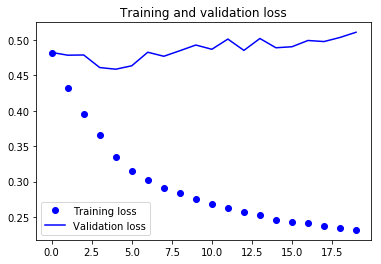

In [21]:
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(loss))

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()


So the reversed-order GRU strongly underperforms even the common-sense baseline, indicating that the in our case chronological processing is very 
important to the success of our approach. This makes perfect sense: the underlying GRU layer will typically be better at remembering the 
recent past than the distant past, and naturally the more recent weather data points are more predictive than older data points in our 
problem (that's precisely what makes the common-sense baseline a fairly strong baseline). Thus the chronological version of the layer is 
bound to outperform the reversed-order version. Importantly, this is generally not true for many other problems, including natural 
language: intuitively, the importance of a word in understanding a sentence is not usually dependent on its position in the sentence. Let's 
try the same trick on the LSTM IMDB example from the previous section:

逆序 GRU 的效果甚至比基于常识的基准方法还要差很多，这说明在本例中，按时间正序处理对成功解决问题很重要。这非常合理：GRU 层通常更善于记住最近的数据，而不是久远的数据，与更早的数据点相比，更靠后的天气数据点对问题自然具有更高的预测能力（这也是基于常识的基准方法非常强大的原因）。因此，按时间正序的模型必然会优于时间逆序的模型。重要的是，对许多其他问题（包括自然语言）而言，情况并不是这样：直觉上来看，一个单词对理解句子的重要性通常并不取决于它在句子中的位置。我们尝试对上一节 IMDB 示例中的 LSTM 应用相同的技巧。

In [22]:
from keras.datasets import imdb
from keras.preprocessing import sequence
from keras import layers
from keras.models import Sequential

# Number of words to consider as features（作为特征的单词个数）
max_features = 10000
# Cut texts after this number of words (among top max_features most common words)
# 在这么多单词之后截断文本（这些单词都属于前 max_features 个最常见的单词）
maxlen = 500

# Load data（加载数据）
(x_train, y_train), (x_test, y_test) = imdb.load_data(num_words=max_features)

# Reverse sequences（将序列反转）
x_train = [x[::-1] for x in x_train]
x_test = [x[::-1] for x in x_test]

# Pad sequences（填充序列）
x_train = sequence.pad_sequences(x_train, maxlen=maxlen)
x_test = sequence.pad_sequences(x_test, maxlen=maxlen)

model = Sequential()
model.add(layers.Embedding(max_features, 128))
model.add(layers.LSTM(32))
model.add(layers.Dense(1, activation='sigmoid'))

model.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['acc'])
history = model.fit(x_train, y_train,
                    epochs=10,
                    batch_size=128,
                    validation_split=0.2)

Train on 20000 samples, validate on 5000 samples
Epoch 1/10
20000/20000 [==============================] - 167s 8ms/step - loss: 0.4854 - acc: 0.7696 - val_loss: 0.4135 - val_acc: 0.8344
Epoch 2/10
20000/20000 [==============================] - 166s 8ms/step - loss: 0.3057 - acc: 0.8842 - val_loss: 0.3418 - val_acc: 0.8568
Epoch 3/10
20000/20000 [==============================] - 166s 8ms/step - loss: 0.2551 - acc: 0.9031 - val_loss: 0.3131 - val_acc: 0.8722
Epoch 4/10
20000/20000 [==============================] - 166s 8ms/step - loss: 0.2175 - acc: 0.9200 - val_loss: 0.6058 - val_acc: 0.8084
Epoch 5/10
20000/20000 [==============================] - 166s 8ms/step - loss: 0.1921 - acc: 0.9314 - val_loss: 0.6356 - val_acc: 0.8154
Epoch 6/10
20000/20000 [==============================] - 166s 8ms/step - loss: 0.1741 - acc: 0.9393 - val_loss: 0.3660 - val_acc: 0.8782
Epoch 7/10
20000/20000 [==============================] - 166s 8ms/step - loss: 0.1544 - acc: 0.9456 - val_loss: 0.4077 - v


We get near-identical performance as the chronological-order LSTM we tried in the previous section.

Thus, remarkably, on such a text dataset, reversed-order processing works just as well as chronological processing, confirming our 
hypothesis that, albeit word order *does* matter in understanding language, *which* order you use isn't crucial. Importantly, a RNN trained 
on reversed sequences will learn different representations than one trained on the original sequences, in much the same way that you would 
have quite different mental models if time flowed backwards in the real world -- if you lived a life where you died on your first day and 
you were born on your last day. In machine learning, representations that are *different* yet *useful* are always worth exploiting, and the 
more they differ the better: they offer a new angle from which to look at your data, capturing aspects of the data that were missed by other 
approaches, and thus they can allow to boost performance on a task. This is the intuition behind "ensembling", a concept that we will 
introduce in the next chapter.

A bidirectional RNN exploits this idea to improve upon the performance of chronological-order RNNs: it looks at its inputs sequence both 
ways, obtaining potentially richer representations and capturing patterns that may have been missed by the chronological-order version alone.

模型性能与正序 LSTM 几乎相同。

值得注意的是，在这样一个文本数据集上，逆序处理的效果与正序处理一样好，这证实了一个假设：虽然单词顺序对理解语言很重要，但使用哪种顺序并不重要。重要的是，在逆序序列上训练的 RNN 学到的表示不同于在原始序列上学到的表示，正如在现实世界中，如果时间倒流（你的人生是第一天死去、最后一天出生），那么你的心智模型也会完全不同。在机器学习中，如果一种数据表示不同但有用，那么总是值得加以利用，这 种表示与其他表示的差异越大越好，它们提供了查看数据的全新角度，抓住了数据中被其他方法忽略的内容，因此可以提高模型在某个任务上的性能。这是集成（ensembling）方法背后的直觉，我们将在下一章介绍集成的概念。

双向 RNN 正是利用这个想法来提高正序 RNN 的性能。它从两个方向查看数据，从而得到更加丰富的表示，并捕捉到仅使用正序 RNN 时可能忽略的一些模式。


![bidirectional rnn](data/bidirectional_rnn.png)

To instantiate a bidirectional RNN in Keras, one would use the `Bidirectional` layer, which takes as first argument a recurrent layer 
instance. `Bidirectional` will create a second, separate instance of this recurrent layer, and will use one instance for processing the 
input sequences in chronological order and the other instance for processing the input sequences in reversed order. Let's try it on the 
IMDB sentiment analysis task:

在 Keras 中将一个双向 RNN 实例化，我们需要使用 Bidirectional 层，它的第一个参数是一个循环层实例。Bidirectional 对这个循环层创建了第二个单独实例，然后使用一个实例按正序处理输入序列，另一个实例按逆序处理输入序列。我们在 IMDB 情感分析任务上来试一下这种方法。

In [23]:
from keras import backend as K
K.clear_session()

In [24]:
model = Sequential()
model.add(layers.Embedding(max_features, 32))
model.add(layers.Bidirectional(layers.LSTM(32)))
model.add(layers.Dense(1, activation='sigmoid'))

model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])
history = model.fit(x_train, y_train, epochs=10, batch_size=128, validation_split=0.2)

Train on 20000 samples, validate on 5000 samples
Epoch 1/10
20000/20000 [==============================] - 332s 17ms/step - loss: 0.5594 - acc: 0.7167 - val_loss: 0.4008 - val_acc: 0.8496
Epoch 2/10
20000/20000 [==============================] - 331s 17ms/step - loss: 0.3295 - acc: 0.8747 - val_loss: 0.3924 - val_acc: 0.8596
Epoch 3/10
20000/20000 [==============================] - 332s 17ms/step - loss: 0.2672 - acc: 0.9014 - val_loss: 0.4422 - val_acc: 0.8650
Epoch 4/10
20000/20000 [==============================] - 333s 17ms/step - loss: 0.2308 - acc: 0.9156 - val_loss: 0.3335 - val_acc: 0.8780
Epoch 5/10
20000/20000 [==============================] - 330s 16ms/step - loss: 0.2089 - acc: 0.9266 - val_loss: 0.3355 - val_acc: 0.8850
Epoch 6/10
20000/20000 [==============================] - 328s 16ms/step - loss: 0.1839 - acc: 0.9365 - val_loss: 0.4771 - val_acc: 0.7986
Epoch 7/10
20000/20000 [==============================] - 329s 16ms/step - loss: 0.1711 - acc: 0.9398 - val_loss: 0.3

It performs slightly better than the regular LSTM we tried in the previous section, going above 88% validation accuracy. It also seems to 
overfit faster, which is unsurprising since a bidirectional layer has twice more parameters than a chronological LSTM. With some 
regularization, the bidirectional approach would likely be a strong performer on this task.

Now let's try the same approach on the weather prediction task:

这个模型的表现比上一节的普通 LSTM 略好，验证精度超过 88%。这个模型似乎也很快就开始过拟合，这并不令人惊讶，因为双向层的参数个数是正序 LSTM 的 2 倍。添加一些正则化，双向方法在这个任务上可能会有很好的表现。

接下来，我们尝试将相同的方法应用于温度预测任务。


In [25]:
from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop

model = Sequential()
model.add(layers.Bidirectional(
    layers.GRU(32), input_shape=(None, float_data.shape[-1])))
model.add(layers.Dense(1))

model.compile(optimizer=RMSprop(), loss='mae')
history = model.fit_generator(train_gen,
                              steps_per_epoch=500,
                              epochs=40,
                              validation_data=val_gen,
                              validation_steps=val_steps)

Epoch 1/40
500/500 [==============================] - 470s 940ms/step - loss: 0.2930 - val_loss: 0.2739
Epoch 2/40
500/500 [==============================] - 466s 932ms/step - loss: 0.2743 - val_loss: 0.2733
Epoch 3/40
500/500 [==============================] - 471s 941ms/step - loss: 0.2665 - val_loss: 0.2690
Epoch 4/40
500/500 [==============================] - 467s 933ms/step - loss: 0.2628 - val_loss: 0.2713
Epoch 5/40
500/500 [==============================] - 467s 934ms/step - loss: 0.2551 - val_loss: 0.2714
Epoch 6/40
500/500 [==============================] - 465s 930ms/step - loss: 0.2485 - val_loss: 0.2743
Epoch 7/40
500/500 [==============================] - 470s 939ms/step - loss: 0.2440 - val_loss: 0.2819
Epoch 8/40
500/500 [==============================] - 474s 948ms/step - loss: 0.2386 - val_loss: 0.2809
Epoch 9/40
500/500 [==============================] - 475s 951ms/step - loss: 0.2322 - val_loss: 0.2803
Epoch 10/40
500/500 [==============================] - 474s 948m


It performs about as well as the regular GRU layer. It's easy to understand why: all of the predictive capacity must be coming from the 
chronological half of the network, since the anti-chronological half is known to be severely underperforming on this task (again, because 
the recent past matters much more than the distant past in this case).

这个模型的表现与普通 GRU 层差不多一样好。其原因很容易理解：所有的预测能力肯定都来自于正序的那一半网络，因为我们已经知道，逆序的那一半在这个任务上的表现非常糟糕（本例同样是因为，最近的数据比久远的数据更加重要）。


## Going even further

At this stage, there are still many other things you could try in order to improve performance on our weather forecasting problem:

* Adjust the number of units in each recurrent layer in the stacked setup. Our current choices are largely arbitrary and thus likely 
suboptimal.
* Adjust the learning rate used by our `RMSprop` optimizer.
* Try using `LSTM` layers instead of `GRU` layers.
* Try using a bigger densely-connected regressor on top of the recurrent layers, i.e. a bigger `Dense` layer or even a stack of `Dense` 
layers.
* Don't forget to eventually run the best performing models (in terms of validation MAE) on the test set! Least you start developing 
architectures that are overfitting to the validation set.   

As usual: deep learning is more an art than a science, and while we can provide guidelines as to what is likely to work or not work on a 
given problem, ultimately every problem is unique and you will have to try and evaluate different strategies empirically. There is 
currently no theory that will tell you in advance precisely what you should do to optimally solve a problem. You must try and iterate.


## Wrapping up

Here's what you should take away from this section:

* As you first learned in Chapter 4, when approaching a new problem, 
it is good to first establish common sense baselines for your metric of choice. If you don't have a 
baseline to beat, you can't tell if you are making any real progress.
* Try simple models before expensive ones, to justify the additional expense. Sometimes a simple model will turn out to be your best option.
* On data where temporal ordering matters, recurrent networks are a great fit and easily outperform models that first flatten the temporal 
data.
* To use dropout with recurrent networks, one should use a time-constant dropout mask and recurrent dropout mask. This is built into Keras 
recurrent layers, so all you have to do is use the `dropout` and `recurrent_dropout` arguments of recurrent layers.
* Stacked RNNs provide more representational power than a single RNN layer. They are also much more expensive, and thus not always worth it. 
While they offer clear gains on complex problems (e.g. machine translation), they might not always be relevant to smaller, simpler problems.
* Bidirectional RNNs, which look at a sequence both ways, are very useful on natural language processing problems. However, they will not 
be strong performers on sequence data where the recent past is much more informative than the beginning of the sequence.

Note there are two important concepts that we will not cover in detail here: recurrent "attention", and sequence masking. Both tend to be 
especially relevant for natural language processing, and are not particularly applicable to our temperature forecasting problem. We will 
leave them for future study outside of this book.

## 更多尝试
为了提高温度预测问题的性能，你还可以尝试下面这些方法。
* 在堆叠循环层中调节每层的单元个数。当前取值在很大程度上是任意选择的，因此可能不是最优的。
* 调节 RMSprop 优化器的学习率。
* 尝试使用 LSTM 层代替 GRU 层。
* 在循环层上面尝试使用更大的密集连接回归器，即更大的 Dense 层或 Dense 层的堆叠。
* 不要忘记最后在测试集上运行性能最佳的模型（即验证 MAE 最小的模型）。否则，你开发的网络架构将会对验证集过拟合。

正如前面所说，深度学习是一门艺术而不是科学。我们可以提供指导，对于给定问题哪些方法可能有用、哪些方法可能没用，但归根结底，每个问题都是独一无二的，你必须根据经验对不同的策略进行评估。目前没有任何理论能够提前准确地告诉你，应该怎么做才能最优地解决问题。你必须不断迭代。

## 小结
下面是你应该从本节中学到的要点。
* 我们在第 4 章学过，遇到新问题时，最好首先为你选择的指标建立一个基于常识的基准。 如果没有需要打败的基准，那么就无法分辨是否取得了真正的进步。
* 在尝试计算代价较高的模型之前，先尝试一些简单的模型，以此证明增加计算代价是有 意义的。有时简单模型就是你的最佳选择。
* 如果时间顺序对数据很重要，那么循环网络是一种很适合的方法，与那些先将时间数据 展平的模型相比，其性能要更好。
* 想要在循环网络中使用 dropout，你应该使用一个不随时间变化的 dropout 掩码与循环 dropout 掩码。这二者都内置于 Keras 的循环层中，所以你只需要使用循环层的 dropout 和 recurrent_dropout 参数即可。
* 与单个 RNN 层相比，堆叠 RNN 的表示能力更加强大。但它的计算代价也更高，因此不 一定总是需要。虽然它在机器翻译等复杂问题上很有效，但在较小、较简单的问题上可能不一定有用。
 
注意：有两个重要的概念我们这里没有详细介绍：循环注意（recurrent attention）和序列掩码（sequence masking）。这两个概念通常对自然语言处理特别有用，但并不适用于温度预测问题。你可以在学完本书后对其做进一步研究。
